# Import libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import timeit
from tqdm import tqdm
import random
import math
import copy
import sys
import string
from collections import Counter
import scipy.optimize as opt
import torch
from tqdm import tqdm
from pyswarm import pso

random.seed(19680801)
np.random.seed(19680801)
torch.manual_seed(19680801)
torch.cuda.manual_seed(19680801)
torch.backends.cudnn.deterministic = True

# Defining functions and algorithms to analyze

## Setting constants

In [55]:
max_n = 3000
mean_count=10
n = np.arange(1, max_n + 1, 1)

## Defining function to get execution time

In [3]:
def get_execution_time(algorithm, *args):
    start_time = timeit.default_timer()

    algorithm(*args)

    return timeit.default_timer() - start_time

## Get the execution time depending on size of input data

In [4]:
def get_execution_time_array(algorithm, *args):
    times_array = []

    for n in tqdm(range (1, max_n +1)):
        execution_time_summ = 0

        for m in range(1, mean_count):
            execution_time_summ += get_execution_time(algorithm, *args)

        execution_time_mean = execution_time_summ / mean_count
        times_array.append(execution_time_mean)

    return np.array(times_array)

In [5]:
def get_execution_time_array_huffman(algorithm, *args):
    times_array = []

    for n in tqdm(range (1, max_n +1)):
        input_str = ''.join(random.choices(string.ascii_uppercase + string.digits, k=n))
        execution_time_summ = 0

        for m in range(1, mean_count):
            execution_time_summ += get_execution_time(algorithm, input_str, *args)

        execution_time_mean = execution_time_summ / mean_count
        times_array.append(execution_time_mean)

    return np.array(times_array)

# Plot Empirical and Theoretical time

In [6]:
def plot_time_graph(empirical, theoretical, name):
    fig, ax = plt.subplots()

    ax.plot(n, empirical, label = 'Empirical time')
    ax.plot(n, theoretical, label = 'Theoretical time')

    ax.set(xlabel='Array size', ylabel='Execution time',title=name)

    ax.legend()
    ax.grid()

    plt.show()

In [7]:
def plot_loss_convegence(loss, prams_history, bounds, optims):
  x = np.linspace(*bounds, 100)
  y = np.linspace(*bounds, 100)
  X, Y = np.meshgrid(x, y)
  Z = loss(X, Y)
  plt.contourf(X, Y, Z, levels=50, cmap='jet')
  prams_history = np.asarray(prams_history)
  plt.plot(prams_history[:, 0], prams_history[:, 1], '.-', color='w')
  for optim in optims:
    plt.plot(optim[0], optim[1], '*', color='r')
  plt.show()

## Part 1

In [8]:
class NodeTree(object):
    def __init__(self, left=None, right=None):
        self.left = left
        self.right = right

    def children(self):
        return self.left, self.right

    def __str__(self):
        return self.left, self.right


def huffman_code_tree(node, binString=''):
    if type(node) is str:
        return {node: binString}
    (l, r) = node.children()
    d = dict()
    d.update(huffman_code_tree(l, binString + '0'))
    d.update(huffman_code_tree(r, binString + '1'))
    return d


def make_tree(nodes):
    while len(nodes) > 1:
        (key1, c1) = nodes[-1]
        (key2, c2) = nodes[-2]
        nodes = nodes[:-2]
        node = NodeTree(key1, key2)
        nodes.append((node, c1 + c2))
        nodes = sorted(nodes, key=lambda x: x[1], reverse=True)
    return nodes[0][0]

In [9]:
def huffman(input_str):
    freq = dict(Counter(input_str))
    freq = sorted(freq.items(), key=lambda x: x[1], reverse=True)
    node = make_tree(freq)
    return huffman_code_tree(node)

100%|██████████| 15000/15000 [00:54<00:00, 273.91it/s]


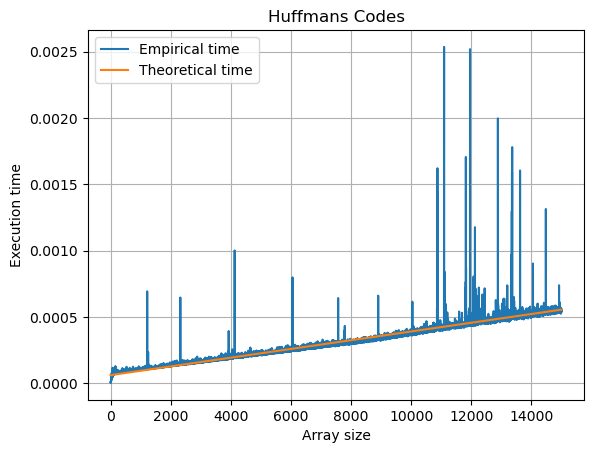

In [10]:
empirical_exec_time = get_execution_time_array_huffman(huffman)

coaf = np.polyfit(n, empirical_exec_time, 1)
polynom_fn = np.poly1d(coaf)

plot_time_graph(empirical_exec_time, polynom_fn(n), 'Huffmans Codes')

## Part 2

In [53]:
def fitness_rastrigin(position):
	fitness_value = 0.0
	for i in range(len(position)):
		xi = position[i]
		fitness_value += (xi * xi) - (10 * math.cos(2 * math.pi * xi)) + 10
	return fitness_value


def fitness_sphere(position):
	fitness_value = 0.0
	for i in range(len(position)):
		xi = position[i]
		fitness_value += (xi * xi)
	return fitness_value


class whale:
	def __init__(self, fitness, dim, minx, maxx, seed):
		self.rnd = random.Random(seed)
		self.position = [0.0 for i in range(dim)]

		for i in range(dim):
			self.position[i] = ((maxx - minx) * self.rnd.random() + minx)

		self.fitness = fitness(self.position) # curr fitness


# whale optimization algorithm(WOA)
def woa(fitness, max_iter, n, dim, minx, maxx, initial_guess):
	rnd = random.Random(0)

	params_history = [initial_guess]

	# create n random whales
	whalePopulation = [whale(fitness, dim, minx, maxx, i) for i in range(n)]

	# compute the value of best_position and best_fitness in the whale Population
	Xbest = initial_guess
	Fbest = sys.float_info.max

	for i in range(n): # check each whale
		if whalePopulation[i].fitness < Fbest:
			Fbest = whalePopulation[i].fitness
			Xbest = copy.copy(whalePopulation[i].position)

	# main loop of woa
	Iter = 0
	while Iter < max_iter:
		# linearly decreased from 2 to 0
		a = 2 * (1 - Iter / max_iter)
		a2=-1+Iter*((-1)/max_iter)

		for i in range(n):
			A = 2 * a * rnd.random() - a
			C = 2 * rnd.random()
			b = 1
			l = (a2-1)*rnd.random()+1
			p = rnd.random()

			D = [0.0 for i in range(dim)]
			D1 = [0.0 for i in range(dim)]
			Xnew = [0.0 for i in range(dim)]
			Xrand = [0.0 for i in range(dim)]
			if p < 0.5:
				if abs(A) > 1:
					for j in range(dim):
						D[j] = abs(C * Xbest[j] - whalePopulation[i].position[j])
						Xnew[j] = Xbest[j] - A * D[j]
				else:
					p = random.randint(0, n - 1)
					while (p == i):
						p = random.randint(0, n - 1)

					Xrand = whalePopulation[p].position

					for j in range(dim):
						D[j] = abs(C * Xrand[j] - whalePopulation[i].position[j])
						Xnew[j] = Xrand[j] - A * D[j]
			else:
				for j in range(dim):
					D1[j] = abs(Xbest[j] - whalePopulation[i].position[j])
					Xnew[j] = D1[j] * math.exp(b * l) * math.cos(2 * math.pi * l) + Xbest[j]

			for j in range(dim):
				whalePopulation[i].position[j] = Xnew[j]

		for i in range(n):
			# if Xnew < minx OR Xnew > maxx
			# then clip it
			for j in range(dim):
				whalePopulation[i].position[j] = max(whalePopulation[i].position[j], minx)
				whalePopulation[i].position[j] = min(whalePopulation[i].position[j], maxx)

			whalePopulation[i].fitness = fitness(whalePopulation[i].position)

			if (whalePopulation[i].fitness < Fbest):
				params_history.append(whalePopulation[i].position)
				Xbest = copy.copy(whalePopulation[i].position)
				Fbest = whalePopulation[i].fitness


		Iter += 1

	return Xbest, params_history

100%|██████████| 3000/3000 [07:40<00:00,  6.51it/s]


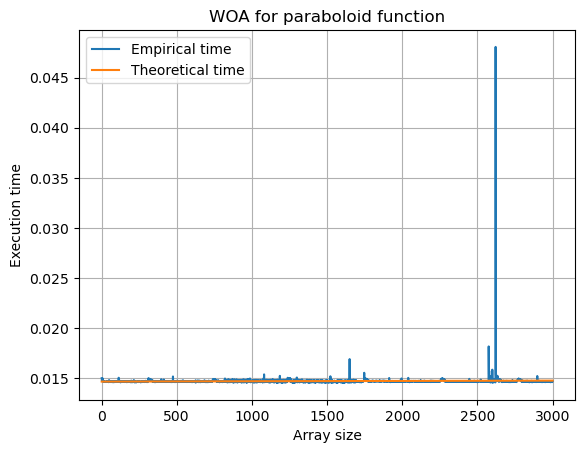

In [56]:
initial_guess = np.array([10,10], dtype=float)
fitness = fitness_sphere

empirical_exec_time = get_execution_time_array(woa, fitness, 100, 50, 2, -10.0, 10.0, initial_guess)

coaf = np.polyfit(n, empirical_exec_time, 1)
polynom_fn = np.poly1d(coaf)

plot_time_graph(empirical_exec_time, polynom_fn(n), 'WOA for paraboloid function')

# Let's try to use WOA to optimize various functions

## Paraboloid

In [26]:
loss = lambda position: position[0]**2 + position[1]**2
initial_guess = np.array([7,7], dtype=float)
global_opt = [0.0, 0.0]
min_lim = -10.0
max_lim =  10.0

dim = 2
num_whales = 20
max_iter = 10

best_position, params_history = woa(loss, max_iter, num_whales, dim, min_lim, max_lim, initial_guess)
err = loss(best_position)

In [27]:
dim = 2
num_whales = 20
max_iter = 10

best_position, params_history = woa(loss, max_iter, num_whales, dim, min_lim, max_lim, initial_guess)
err = loss(best_position)

print(f'Known global optimum {global_opt}')
print(f'Global loss value {loss(global_opt)}')
print(f'Predicted optimum {best_position}')
print(f'Predicted loss value {err}')
print(f'Accuracy = {(loss(global_opt) - err)**2}')

Known global optimum [0.0, 0.0]
Global loss value 0.0
Predicted optimum [-0.308282977186673, 0.28981467732156013]
Predicted loss value 0.17903094121407878
Accuracy = 0.03205207791199893


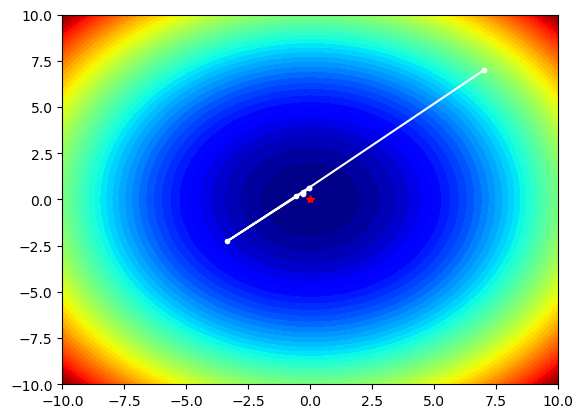

In [28]:
loss_fun = lambda x, y: x**2 + y**2
plot_loss_convegence(loss_fun, params_history, [min_lim, max_lim], [global_opt])

## Himmelblau

In [29]:
loss = lambda position: (position[0]**2 + position[1] - 11)**2 + (position[0] + position[1]**2 - 7)**2
global_optims = [[3.0, 2.0], [-2.805118, 3.131312], [-3.779310, -3.283186], [3.584428, -1.848126]]
initial_guess = np.array([0, 0])

dim = 2
num_whales = 20
max_iter = 10

best_position, params_history = woa(loss, max_iter, num_whales, dim, min_lim, max_lim, initial_guess)
err = loss(best_position)
best_position

[-3.795266199743274, -3.2373162948200065]

In [30]:
difference_array = np.square(np.array(global_optims) - np.array(best_position))
sum_square = np.sum(difference_array)
index = sum_square.argmin()

global_opt = global_optims[index]
global_loss_value = loss(global_opt)

print(f'Known global optimum {global_opt}')
print(f'Global loss value {global_loss_value}')
print(f'Predicted optimum {best_position}')
print(f'Predicted loss value {err}')
print(f'Accuracy = {(global_loss_value - err)**2}')

Known global optimum [3.0, 2.0]
Global loss value 0.0
Predicted optimum [-3.795266199743274, -3.2373162948200065]
Predicted loss value 0.12705476570839289
Accuracy = 0.016142913489214608


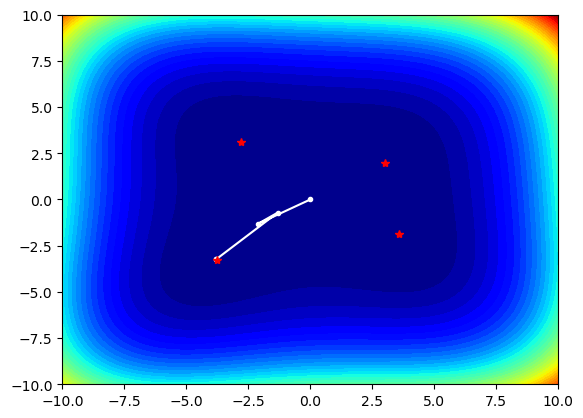

In [31]:
loss_fun = lambda x, y: (x**2 + y - 11)**2 + (x + y**2 - 7)**2
plot_loss_convegence(loss_fun, params_history, [min_lim, max_lim], global_optims)

## Ackley

In [32]:
global_opt = [0.0, 0.0]
initial_guess = np.array([-4,-4])
loss = lambda position: -20.0 * np.exp(-0.2 * np.sqrt(0.5 * (position[0]**2 + position[1]**2))) - np.exp(0.5 * (np.cos(2 * np.pi * position[0]) + np.cos(2 * np.pi * position[1]))) + np.e + 20

dim = 2
num_whales = 20
max_iter = 10

best_position, params_history = woa(loss, max_iter, num_whales, dim, min_lim, max_lim, initial_guess)
err = loss(best_position)
best_position

[-0.019196506451010384, 0.9695631545535794]

In [33]:
print(f'Known global optimum {global_opt}')
print(f'Global loss value {loss(global_opt)}')
print(f'Predicted optimum {best_position}')
print(f'Predicted loss value {err}')
print(f'Accuracy = {(loss(global_opt) - err)**2}')

Known global optimum [0.0, 0.0]
Global loss value 0.0
Predicted optimum [-0.019196506451010384, 0.9695631545535794]
Predicted loss value 2.597535914429759
Accuracy = 6.747192826752445


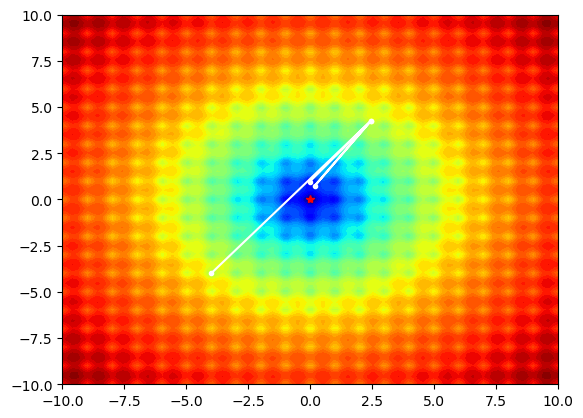

In [34]:
loss_fun = lambda x,y: -20.0 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2))) - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))) + np.e + 20
plot_loss_convegence(loss_fun, params_history, [min_lim, max_lim], [global_opt])

# Comparing WOA with other optimisation method

In [35]:
x = 3 * np.linspace(0, 1001, 1001) / 1000

y = 1 / (x**2 - 3*x + 2)

y[y < -100] = -100 + np.random.normal(0, 1, len(y[y < -100]))
y[y > 100] = 100 + np.random.normal(0, 1, len(y[y > 100]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


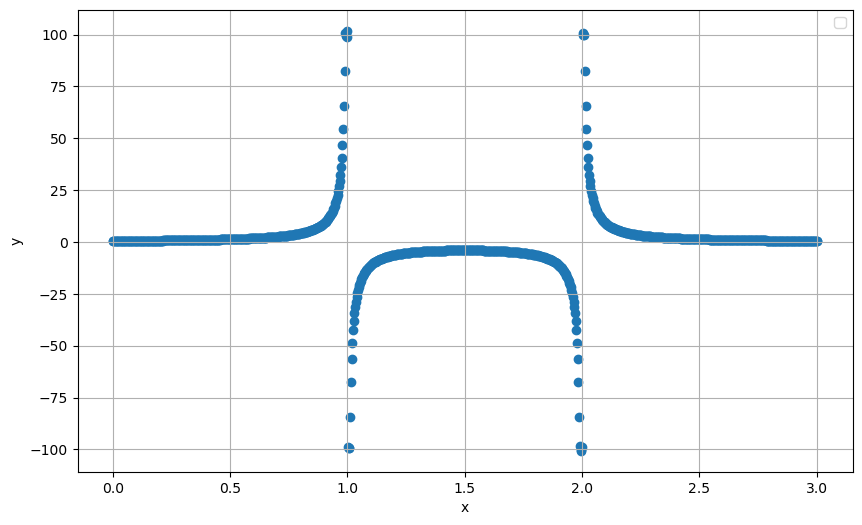

In [36]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x, y)
ax.set(xlabel='x', ylabel='y')
ax.legend()
ax.grid()
plt.show()

# Some more functions for graphs

In [37]:
colors = ['b','g','r','c','m','y','k']

def plot_aprox_result(x, y, methods_and_coafs, aprox_func, aprox_method_name, plot_full_only = False, figsize=(6,10), linewidth=3):

    if plot_full_only:
       num_of_plots = 1
    else:
        num_of_plots = len(methods_and_coafs) + 1

    fig, ax = plt.subplots(num_of_plots, figsize=(10, num_of_plots * 5))

    fig.suptitle(aprox_method_name)

    if not plot_full_only:
        for idx, (method) in enumerate(methods_and_coafs) :
            ax[idx].scatter(x, y)
            coef = methods_and_coafs[method]

            color = colors[idx]
            ax[idx].plot(x, aprox_func(x, *coef), linewidth=linewidth, label=method, color=color)
            ax[idx].set(xlabel='x_cities', ylabel='y')

            ax[idx].legend()
            ax[idx].grid()

        num_of_plots -= 1
        ax[num_of_plots].scatter(x, y)
        ax[num_of_plots].set(xlabel='x', ylabel='y')

        for idx, (method) in enumerate(methods_and_coafs):

            coef = methods_and_coafs[method]
            print(coef)

            color = colors[idx]
            ax[num_of_plots].plot(x, aprox_func(x, *coef), linewidth=linewidth, label=method, color=color)

            ax[num_of_plots].legend()
            ax[num_of_plots].grid()
    else:
        ax.scatter(x, y)
        ax.set(xlabel='x', ylabel='y')

        for idx, (method) in enumerate(methods_and_coafs):

            coef = methods_and_coafs[method]
            print(coef)

            color = colors[idx]
            ax.plot(x, aprox_func(x, *coef ), linewidth=linewidth, label=method, color=color)

            ax.legend()
            ax.grid()

    plt.show()

# Defining loss functions for regression

In [38]:
def rational(x, a, b, c, d):
    return (a * x + b) / (x**2 + c * x + d)

#Spesial version for loss to use in scipy optimisation
def loss_rational(z, *params):
    x, y = params
    a, b, c, d  = z
    return np.sum((rational(x, a, b, c, d) - y)**2)

#Spesial version for loss to use in LMA method
def loss_rational_lma(z, *params):
    x, y = params
    a, b, c, d = z
    return rational(x, a, b, c, d) - y

#Functional version for loss to calc precision
def f_loss_rational(x, y, a, b, c, d):
    return np.sum((rational(x, a, b, c, d) - y)**2)

# Calculating regression coefs by different methods

## Nelder-Mead

In [39]:
eps = 0.001

initial_guess = [0.1, 0.1, 0.1, 0.1]
nelder_mead = opt.minimize(loss_rational, initial_guess, args=(x,y), method='Nelder-Mead', tol = eps)

nelder_mead_result = [nelder_mead['nit'], nelder_mead['nfev'], nelder_mead['fun']]

## Levenberg-Marquardt rational

In [40]:
initial_guess = [-0.1, -0.1, 0.1, 0.1]
lma = opt.least_squares(loss_rational_lma, initial_guess, args=(x,y), ftol=eps, xtol=eps, method='lm')

lma_result = [len(lma['fun']), lma['nfev'], lma['cost']]

## Differential evolution

In [41]:
bounds = np.array([[-10, 10],[-10, 10],[-10, 10],[-10, 10]])
diff_evo = opt.differential_evolution(loss_rational, bounds, args=(x, y), tol=eps)
diff_evo

diff_evo_result = [diff_evo['nit'], diff_evo['nfev'], diff_evo['fun']]

## Swarm

In [42]:
lower_bound = np.array([-10]*4)
upper_bound = np.array([10]*4)
swam, fopt = pso(loss_rational, lower_bound, upper_bound, maxiter=1000, args=(x, y), swarmsize=1000, minfunc=0.001, debug=True)
swam = list(swam)

swarm_result = [145, 145, 197350.7498386208]

No constraints given.
Best after iteration 1: [-6.08247528  5.31896855 -0.12889035  2.98542476] 264297.4709544026
Best after iteration 2: [-6.08247528  5.31896855 -0.12889035  2.98542476] 264297.4709544026
New best for swarm at iteration 3: [-4.30085413  3.51830207  0.25627857  1.6147723 ] 264195.4100281327
New best for swarm at iteration 3: [-2.48911235  1.04370361 -1.96884074  1.75891194] 263143.2836260695
Best after iteration 3: [-2.48911235  1.04370361 -1.96884074  1.75891194] 263143.2836260695
New best for swarm at iteration 4: [-0.42774587  0.27192219 -3.15056823  2.59764647] 260876.8266164675
New best for swarm at iteration 4: [-1.98230131  1.45196762 -2.41990041  1.76253891] 260691.98584779174
Best after iteration 4: [-1.98230131  1.45196762 -2.41990041  1.76253891] 260691.98584779174
Best after iteration 5: [-1.98230131  1.45196762 -2.41990041  1.76253891] 260691.98584779174
Best after iteration 6: [-1.98230131  1.45196762 -2.41990041  1.76253891] 260691.98584779174
New best f

## WOA

In [46]:
initial_guess = np.array([0,0,0,0], dtype=float)
dim = 4
num_whales = 5000
max_iter = 100
min_lim = -10.0
max_lim =  10.0

best_position, params_history = woa(loss_rational, max_iter, num_whales, dim, min_lim, max_lim, initial_guess, args=(x,y))

err = loss_rational(best_position, x,y)
best_position
woa_result = [max_iter, max_iter*num_whales, err]
woa_result

[100, 500000, 219992.26949321217]

# Combined graphs

[ 0.72505238 -1.45111106 -4.00254615  4.00510258]
[-0.09899527 -0.05924876  0.10606983  0.12922116]
[-0.98205646  0.98351803 -2.00276681  1.00278415]
[-1.8945818976950741, 1.8975324668875944, -2.002569050734914, 1.002654077635082]
[-0.6294961066599664, 0.6196236474440667, -2.0231915503326117, 1.0236445952583448]


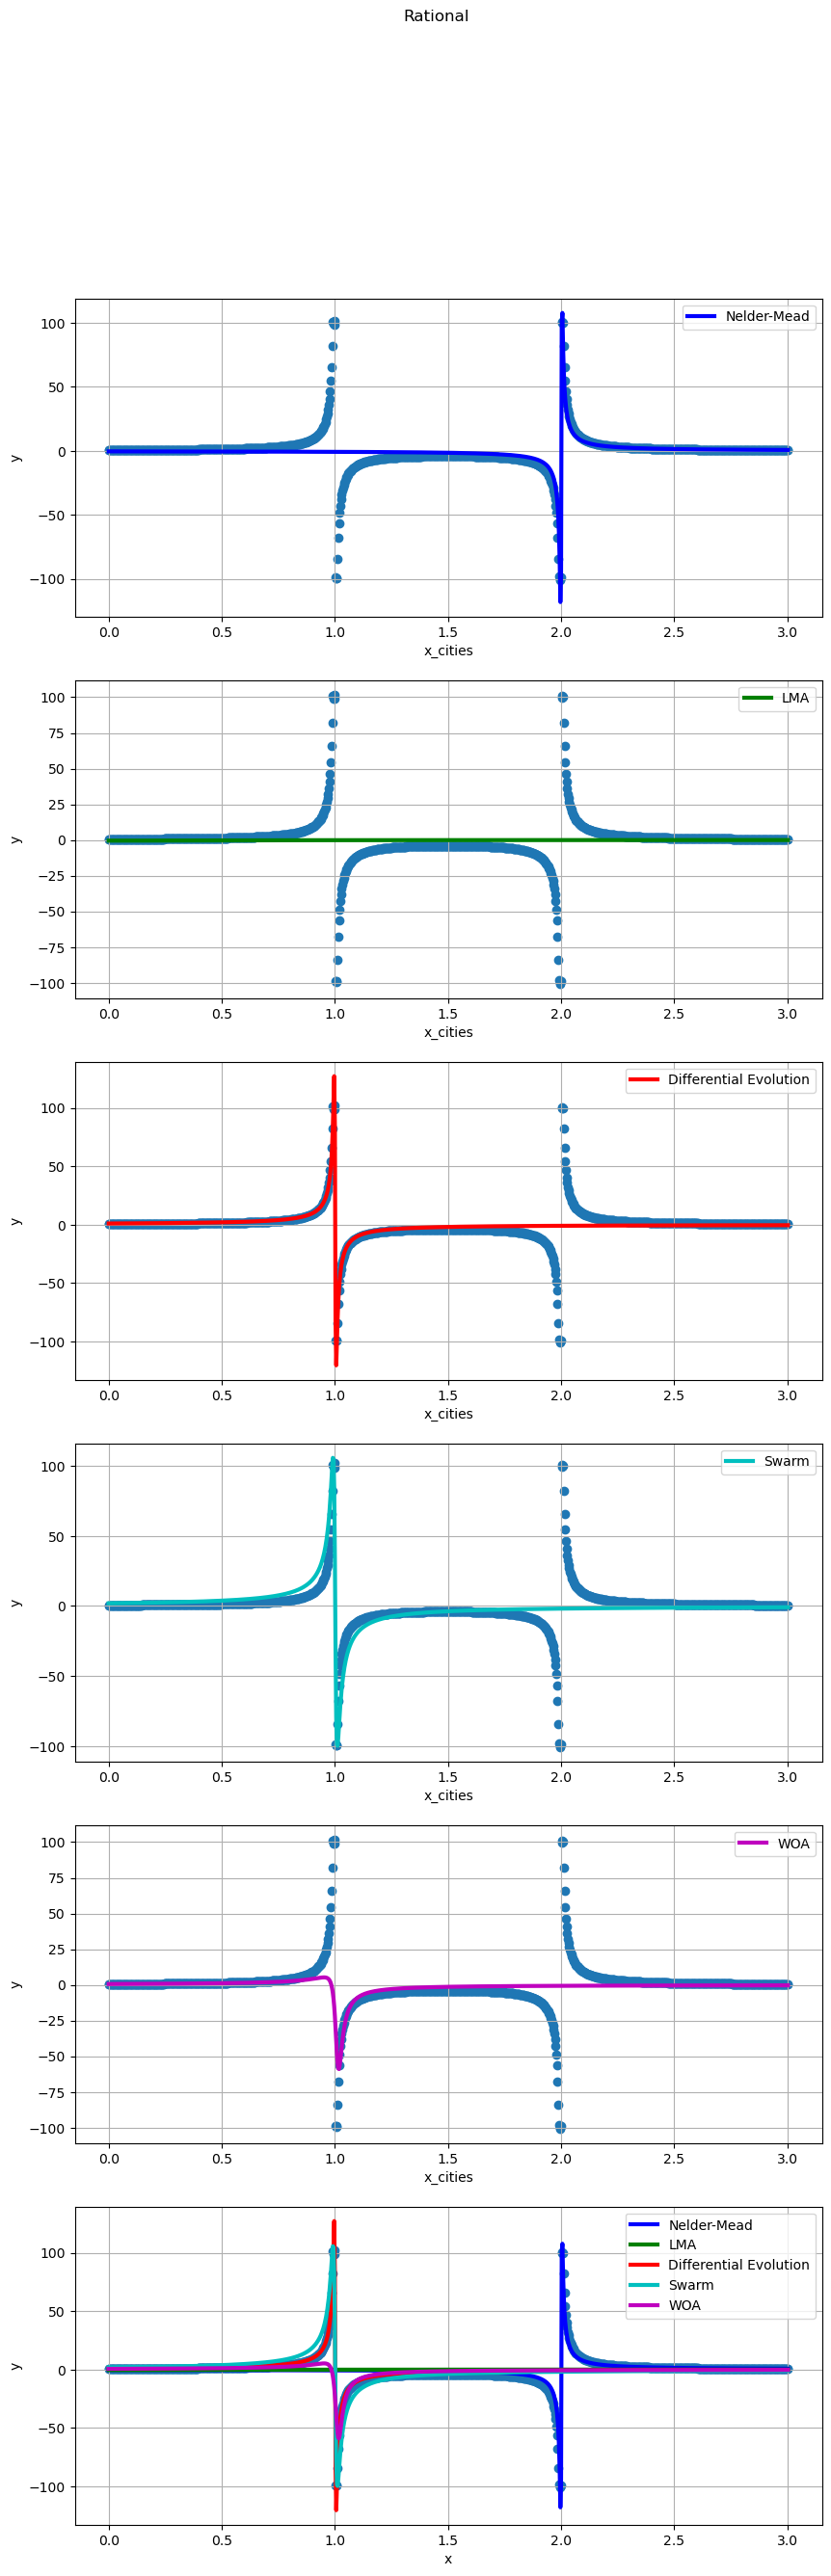

In [47]:
methods_and_coafs_full = {
    'Nelder-Mead': nelder_mead['x'],
    'LMA': lma['x'],
    'Differential Evolution': diff_evo['x'],
    'Swarm':swam,
    'WOA':best_position
}

plot_aprox_result(x, y, methods_and_coafs_full, rational, 'Rational',figsize=(10,20))

In [49]:
df_rational = pd.DataFrame([nelder_mead_result, lma_result, swarm_result,
                          diff_evo_result, woa_result],
                         columns=['iter_count', 'f_calc_count', 'precision'],
                         index=["Nelder-Mead", "Levenberg-Marquardt algorithm",
                                "Particle Swarm Optimization", "Differential Evolution", 'Whale Optimization Algorithm'])
df_rational

,iter_count,f_calc_count,precision
Nelder-Mead,247,430,139959.387734
Levenberg-Marquardt algorithm,1001,9,132655.118966
Particle Swarm Optimization,145,145,197350.749839
Differential Evolution,150,9275,134537.903403
Whale Optimization Algorithm,100,500000,219992.269493
